# Advection or Transport Problem

Considering a one-dimensional domain $ \Omega = \{ x\in \mathbb{R}\space|-2\leq x\leq 2 \} $ and $ \tau = \{ t \in \mathbb{R*}\space|\space t>0\}$

### Differential Equation: 
$$ \frac{\partial u}{\partial t} + a\frac{\partial u}{\partial x} = 0 $$ 

where $u$ is the advected quantity and $a$ is the advected speed. For current simulation, $a$ is a constant and is equal to $0.8$.

### Initial Condition:
$$ u_0(x) = \exp\left(-\frac{1}{2}\left(\frac{x}{0.4}\right)^2\right) $$

### Boundary Condition (Periodic):
$$ u(-2,t) = u(2,t) $$

## 1. Setup

In [1]:
import numpy as np
import tensorflow as tf
# import deepxde as dde
import matplotlib.pyplot as plt

In [2]:
# declaring constants
a = 0.8 # advected speed
L = 2.0 # boundary
T = 10 # maximum time

## 2. Creating Model

In [3]:
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(layer, activation='relu') for layer in layers]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)
        
    def build(self, input_shape):
        for layer in self.hidden_layers:
            layer.build(input_shape)
            input_shape = (input_shape[0], layer.units)
        self.output_layer.build(input_shape)
        super(PINN, self).build(input_shape)
        
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

In [4]:
# Define the pde
def pde(u, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_val = u(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_val, t)
        u_x = tape.gradient(u_val, x) 
    return u_t + a * u_x

In [5]:
# Initial Condition
def initial_condition(x):
    return tf.exp( -0.5 * (x/0.4)**2 )

layers = [15,15]

## 3. Loss Function

In [6]:
def loss(model, x, t):
    # ic
    t_zeros = tf.zeros_like(x)
    u_val = model(tf.concat([x, t_zeros], axis=1))
    u_0 = initial_condition(x)
    u_val = tf.cast(u_val, dtype=tf.float32)
    u_0 = tf.cast(u_0, dtype=tf.float32)
    ic_loss = tf.reduce_mean(tf.square(u_val - u_0))
    
    # residual
    residual = pde(model, x, t)
    residual = tf.cast(residual, dtype=tf.float32)
    residual_loss = tf.reduce_mean(tf.square(residual))
    
    # bc
    bc_left = model(tf.concat([-L * tf.ones_like(t, dtype=tf.float32), t], axis=1)) 
    bc_right = model(tf.concat([L * tf.ones_like(t, dtype=tf.float32), t], axis=1))
    bc_loss = tf.reduce_mean(tf.square(bc_left - bc_right))
    
    total_loss = ic_loss + residual_loss + bc_loss
    
#   return tf.reduce_mean(tf.square(u_val - u_0)) + tf.reduce_mean(tf.square(residual)) + tf.reduce_mean(tf.square(bc_left - bc_right))
    return total_loss

## 4. Training the Model

In [7]:
model = PINN(layers) 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Define the optimizer

@tf.function
def train_step(model, x, t):
    with tf.GradientTape() as tape: 
        current_loss = loss(model, x, t) 
    gradients = tape.gradient(current_loss, model.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return current_loss


loss_history = []
# Training loop 
epochs = 10000
for epoch in range(epochs): 
    x = np.random.normal(loc=0, scale=0.25, size=150)
    x = x[(x >= -L) & (x <= L)]
    t = tf.linspace(0, T, 100)[:, tf.newaxis]
    x, t = tf.meshgrid(x, t) 
    x = tf.reshape(x, [-1, 1])
    t = tf.reshape(t, [-1, 1])
    x = tf.cast(x, dtype=tf.float32)
    t = tf.cast(t, dtype=tf.float32)
#     print(x.dtype, " ", t.dtype)
    current_loss = train_step(model, x, t)
    loss_history.append(current_loss.numpy())
    if (epoch % 1000 == 0):
        tf.print("Epoch", epoch, "Loss:", current_loss)
    if (epoch == 9999):
        tf.print("Epoch", epoch, "Loss:", current_loss)

model.summary()

Epoch 0 Loss: 1.15917349
Epoch 1000 Loss: 0.00311875576
Epoch 2000 Loss: 0.00060219859
Epoch 3000 Loss: 0.000665443717
Epoch 4000 Loss: 0.000408677413
Epoch 5000 Loss: 0.000171910171
Epoch 6000 Loss: 5.83064138e-05
Epoch 7000 Loss: 0.000428050174
Epoch 8000 Loss: 0.000549752556
Epoch 9000 Loss: 0.000713701069
Epoch 9999 Loss: 0.000179156865


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (15000, 15)                 │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (15000, 15)                 │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (15000, 1)                  │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Visualization 

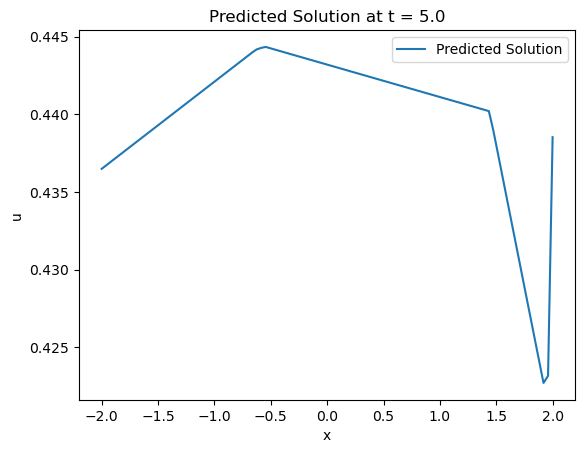

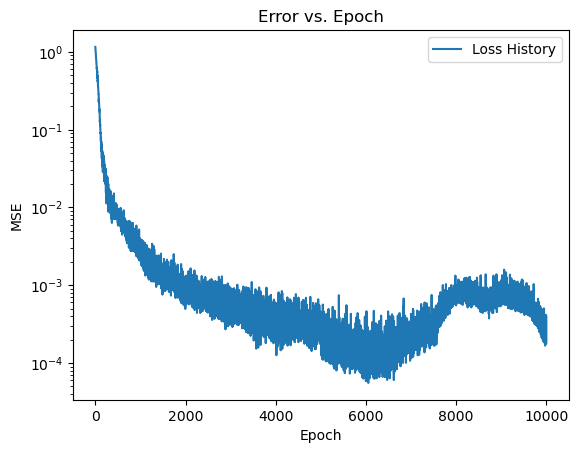

In [14]:
x_test = tf.linspace(-L, L, 100)[:, tf.newaxis] 
t_const = tf.constant(5.0, shape=(100, 1)) # Example: t = 5.0
u_pred = model(tf.concat([x_test, t_const], axis=1))

plt.plot(x_test, u_pred, label="Predicted Solution") 
plt.xlabel("x") 
plt.ylabel("u") 
plt.title("Predicted Solution at t = 5.0") 
plt.legend() 
plt.show()

plt.semilogy(range(epochs), loss_history, label='Loss History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Error vs. Epoch')
plt.legend()
plt.show()

In [15]:
t_test = tf.linspace(0, T, 100)[:, tf.newaxis]
u_pred2 = model(tf.concat([x_test, t_test], axis=1))

x_test = tf.cast(x_test, tf.float32)
t_test = tf.cast(t_test, tf.float32)

x_np = tf.reshape(x_test, (100, 100)).numpy()
t_np = tf.reshape(t_test, (100, 100)).numpy()
u_pred_np = tf.reshape(u_pred2, (100, 100)).numpy()

plt.figure(figsize=(10, 6))

contour = plt.contourf(x_test, t_test, u_pred, cmap='viridis')
plt.colorbar(contour)

# Add labels and title
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour Plot of u')
plt.show()

InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:ConcatV2] name: concat